In [14]:
import os
import numpy as np
import pandas as pd
from textwrap import wrap
from pathlib import Path
from collections import defaultdict

import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [5]:
%config InlineBackend.figure_format = "retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Download google play reviews data

from google_play_scraper import Sort, reviews_all

scrapreview = reviews_all(
    "com.bca",
    lang="id",
    sort=Sort.MOST_RELEVANT,
    filter_score_with=None
)

#### Set intial variables and constants

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.12.0

numpy       : 1.24.2
pandas      : 2.0.0
torch       : 2.0.0+cu117
transformers: 4.27.4



### Loading Data

In [7]:
BASE_PATH = Path().parent.resolve()
DATA_DIR = os.path.join(BASE_PATH, "data")
RAW_DATA_DIR = os.path.join(BASE_PATH, "data", "raw")
PREPROCESS_DATA_DIR = os.path.join(BASE_PATH, "data", "preprocess")

In [8]:
df = pd.read_parquet(os.path.join(RAW_DATA_DIR, "google_play_reviws.parquet"))

In [9]:
df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,97cdb5f7-e26a-4951-9c15-e95f56c8add1,Mahendra Tama,https://play-lh.googleusercontent.com/a/AGNmyx...,"Update tambah ngeselin, tidak bisa verifikasi ...",1,69,4.0.3,2023-03-17 12:33:28,"Mohon maaf atas ketidaknyamanan Bapak/Ibu, unt...",2023-03-17 12:38:06
1,62ab18ff-07d7-4b91-822d-5d048dc84c68,Arifin Nurdin,https://play-lh.googleusercontent.com/a-/ACB-R...,"Sekitar pukul 05.00. Saya coba aktifkan, pulsa...",1,247,4.0.3,2023-03-01 02:55:13,"Mohon maaf atas ketidaknyamanan Bapak/Ibu, moh...",2023-03-01 03:52:33


In [10]:
score_df = df["score"].value_counts().reset_index()
score_df

,score,count
0,5,66809
1,1,31761
2,4,9207
3,3,9141
4,2,8452


In [11]:
# # creating sentiments scoring
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df["sentiment"] = df.score.apply(to_sentiment)
df["sentiment"].value_counts()

sentiment
2    76016
0    40213
1     9141
Name: count, dtype: int64

### Data Processing

1. Add special tokens to separate sentences and do classification
2. Pass sequences of constant length (introduce padding)
3. Create array of 0s (pad token) and 1s (real token) called attention mask

In [12]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

# # load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."
     
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


#### Special Tokens

- [SEP] - marker for ending of a sentence
- [CLS] - marker for start of a sentence
- [PAD] - marker for pad of a sentence
- [UNK] - marker for unknown of a sentence

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [18]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors="pt",  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [19]:
# # The token ids are now stored in a Tensor and padded to a length of 32
print(len(encoding["input_ids"][0]))
encoding["input_ids"][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
# # The attention mask has the same length
print(len(encoding["attention_mask"][0]))
encoding["attention_mask"]

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

#### Choosing Sequence Length

BERT works with fixed-length sequences.

In [21]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160.')

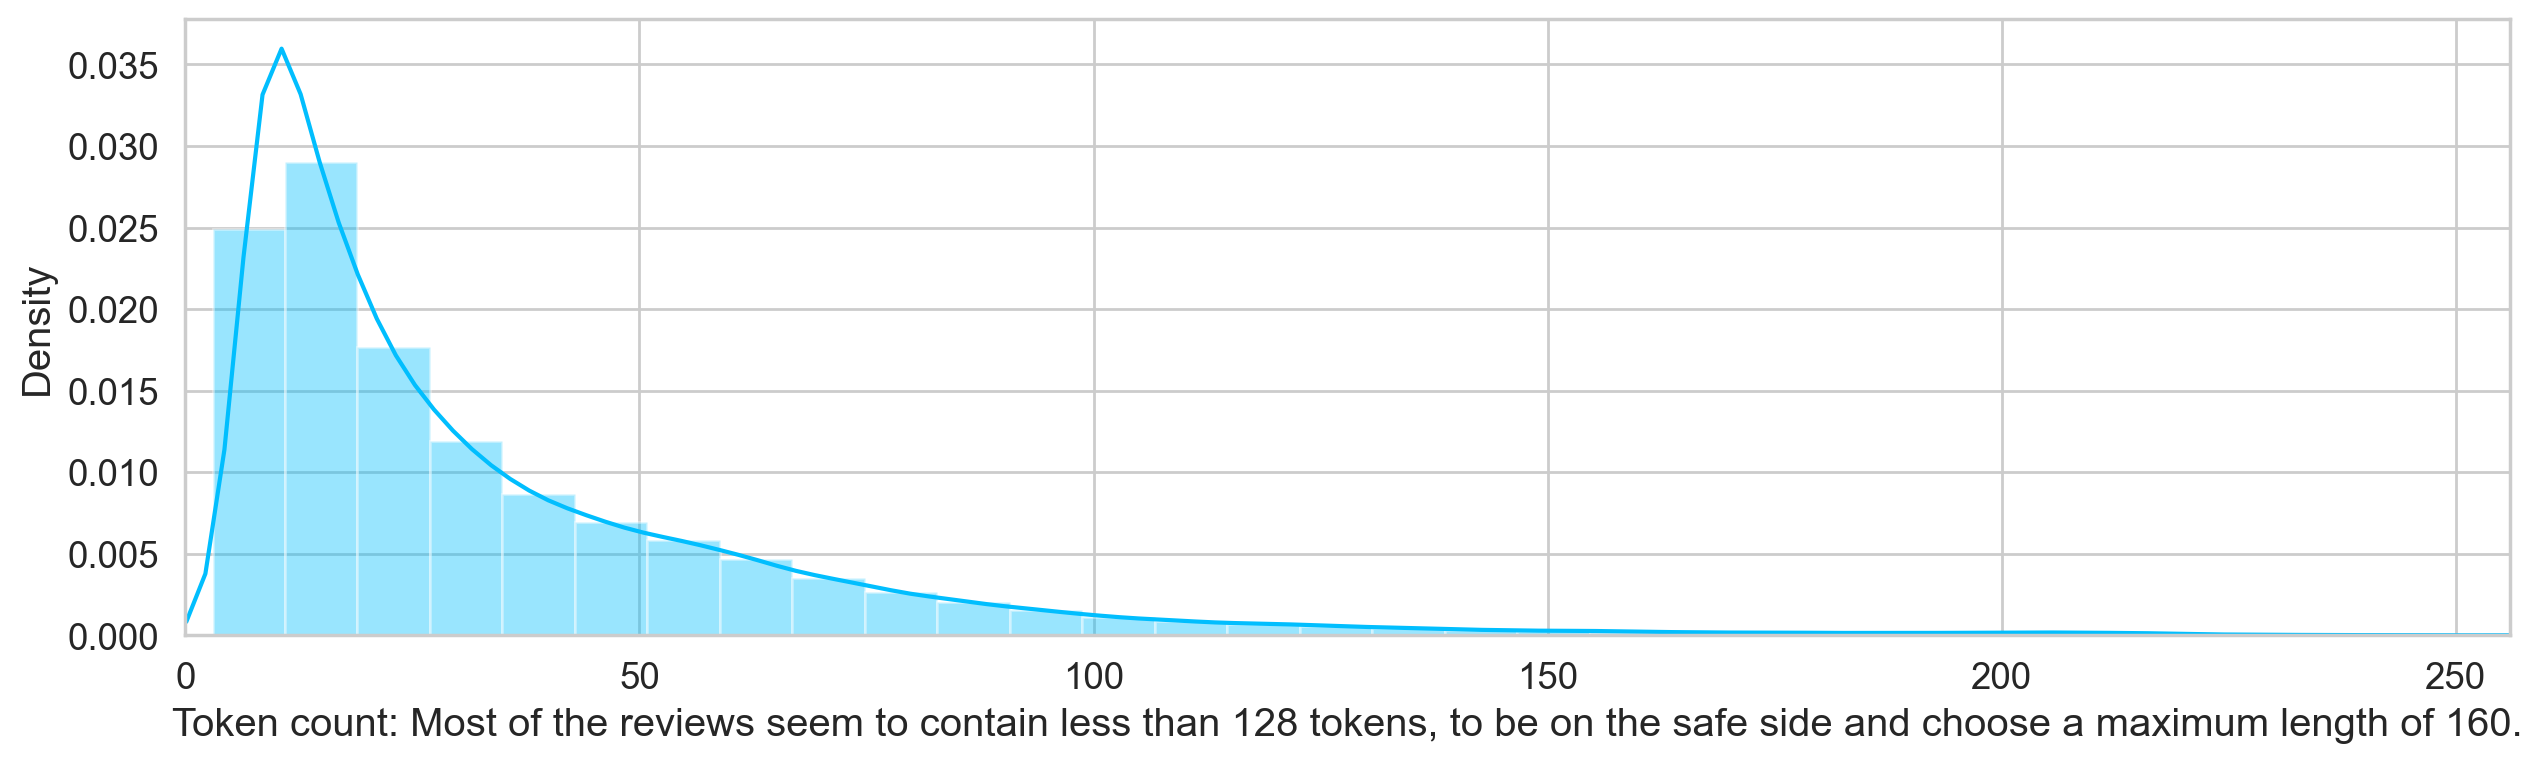

In [22]:
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel("""Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160.""")

### BERT Model

In [23]:
MAX_LEN = 160

In [24]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  
  def __len__(self):
    return len(self.reviews)
  
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors="pt",
    )

    return {
      "review_text": review,
      "input_ids": encoding["input_ids"].flatten(),
      "attention_mask": encoding["attention_mask"].flatten(),
      "targets": torch.tensor(target, dtype=torch.long)
    }

In [25]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((112833, 11), (6268, 11), (6269, 11))

In [ ]:
df_train.to_parquet(os.path.join(PREPROCESS_DATA_DIR, "train.parquet"))
df_val.to_parquet(os.path.join(PREPROCESS_DATA_DIR, "validation.parquet"))
df_test.to_parquet(os.path.join(PREPROCESS_DATA_DIR, "test.parquet"))

In [26]:
# # Creating data loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [47]:
data = next(iter(train_data_loader))
data.keys()

print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)
     

### Sentiment Classification with BERT and Hugging Face

In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
last_hidden_state = bert_model(
  input_ids=encoding["input_ids"], 
  attention_mask=encoding["attention_mask"]
)[0]

pooled_output = bert_model(
  input_ids=encoding["input_ids"], 
  attention_mask=encoding["attention_mask"]
)[1]

In [42]:
# # hidden state for each of our 32 tokens & 768 of hidden units
last_hidden_state.shape

torch.Size([1, 32, 768])

In [43]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
class_names = ["negative", "neutral", "positive"]

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

NameError: name 'data' is not defined

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

NameError: name 'F' is not defined

### Training

To reproduce the training procedure from the BERT paper, AdamW optimizer provided by Hugging Face will be used. It corrects weight decay, so it's similar to the original paper. Linear scheduler with no warmup steps is also used:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4


In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
     

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f"Epoch {epoch + 1}/{EPOCHS}")
  print("-" * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f"Train loss {train_loss} accuracy {train_acc}")

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f"Val   loss {val_loss} accuracy {val_acc}")
  print()

  history["train_acc"].append(train_acc)
  history["train_loss"].append(train_loss)
  history["val_acc"].append(val_acc)
  history["val_loss"].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), "best_model_state.bin")
    best_accuracy = val_acc

In [ ]:
plt.plot(history["train_acc"], label="train accuracy")
plt.plot(history["val_acc"], label="validation accuracy")

plt.title("Training History")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
  plt.ylabel("True Sentiment")
  plt.xlabel("Predicted Sentiment");

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  "class_names": class_names,
  "values": y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f"True Sentiment: {class_names[true_sentiment]}")

In [ ]:
sns.barplot(x="values", y="class_names", data=pred_df, orient="h")
plt.ylabel("sentiment")
plt.xlabel("probability")
plt.xlim([0, 1]);

### Predict on Raw Text

In [ ]:
review_text = "Today I learn something new, this is great!"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors="pt",
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')